In [2]:
import numpy as np
import scipy.sparse as sp
import ReservoirComputer3_2 as ReCom
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
from scipy.interpolate import splprep, splev
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import ReservoirPlot as resplt
import copy

# Synaptic Plasticity Rule:

In [3]:
# Generate training and validation data.
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def lorenz_tpe(u, t, args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = args[0], args[1], args[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def RK4_step(x, dt, f, args):
    k_1 = f(x, 0, args)
    k_2 = f(x + dt*k_1/2, 0, args)
    k_3 = f(x + dt*k_2/2, 0, args)
    k_4 = f(x + dt*k_3, 0, args)
    return 1/6*dt*(k_1 + 2*k_2 + 2*k_3 + k_4)


def tpe(u_hat, dt, f, args):
    # Calculate approx. and ideal movement vectors.
    delta_hat = np.diff(u_hat, axis=0)
    delta = np.asarray([RK4_step(u_hat[i], dt, f, args) for i in range(u_hat.shape[0] - 1)])
    
    # Calculate norms of ideal movement vectors approx. movement vector error.
    delta_norm = np.linalg.norm(delta, axis=1)
    error_norm = np.linalg.norm(delta_hat - delta, axis=1)
    
    # Return TPE.
    return 1/(dt*u_hat.shape[0])*np.sum(np.multiply(error_norm, 1/delta_norm))


T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

In [4]:
class SPESN(ReCom.ESN):
    """
    Implementation of an echo state network (ESN) augmented with an anti-Hebbian
    synaptic plasticity rule. Subclass of ESN.
        
    Instance Variables:
            eta_s (double): Learning rate for synaptic plasticity rule.
            epochs_s (int): Number of training epochs for plasticity rule.
    """
          
    def __init__(self, N, p, d, rho, sigma, gamma, beta, eta_s, epochs_s, seed=1):
        ReCom.ESN.__init__(self, N, p, d, rho, sigma, gamma, beta, seed)
        self.eta_s = eta_s
        self.epochs_s = epochs_s
        
        
    def f_PR(self, r, t, *args):
        v = self.W_out.dot(self.q(r))
        f = self.gamma*(-r + np.tanh(self.M.dot(r) + self.W_in.dot(v)))
        return np.squeeze(np.asarray(f))
    
    
    def f_LR(self, r, t, *args):
        f = self.gamma*(-r + np.tanh(self.M.dot(r) + self.W_in.dot(self.u(t))))
        return np.squeeze(np.asarray(f))
    
    
    def SP_train(self, data, t_points, t_listen, reset_M=True, scale_M=0, store_values=False):
        if reset_M:
            self.rho = self.rho 
        self.u = self.spline(data, t_points)
        
        if store_values:
            M_list = np.zeros((self.epochs_s, t_points.size-t_listen, self.N, self.N))
            self.M = self.M.todense()
    
        for e in range(self.epochs_s):
            if store_values:
                M_list[e, 0] = copy.deepcopy(self.M)
            x = integrate.odeint(self.f_LR, np.zeros(self.N), t_points)
            for t in range(t_listen, data.shape[0]-1):
                self.M = self.M - self.eta_s*(np.asarray([x[t+1]]).T)@np.asarray([x[t]])       
                if store_values:
                    M_list[e, t-t_listen+1] = copy.deepcopy(self.M)
            
            # If scale_M==1, scale M after each epoch to have spectral radius rho.
            if scale_M==1:
                self.M = sp.csr_matrix(self.M)
                max_eval = np.abs(sp.linalg.eigs(self.M, 1, which='LM', return_eigenvectors=False)[0])
                self.M = (self.rho/max_eval)*self.M
            
        
        # If scale_M==2, scale M once after training to have spectral radius rho.
        if scale_M==2:
                self.M = sp.csr_matrix(self.M)
                max_eval = np.abs(sp.linalg.eigs(self.M, 1, which='LM', return_eigenvectors=False)[0])
                self.M = (self.rho/max_eval)*self.M
                
        # If scale_M==0, don't rescale M during training.
        else:
                self.M = sp.csr_matrix(self.M)
        
        if store_values:
            return M_list

In [5]:
RC = SPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_s=1e-6, epochs_s=10)

In [6]:
%%time
train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 2.32 s


In [7]:
%%time
M_list = RC.SP_train(train_data, t_points_training, t_listen=5000, store_values=True)
sp_train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction_sp = RC.predict(t_points_prediction)

Wall time: 21.3 s


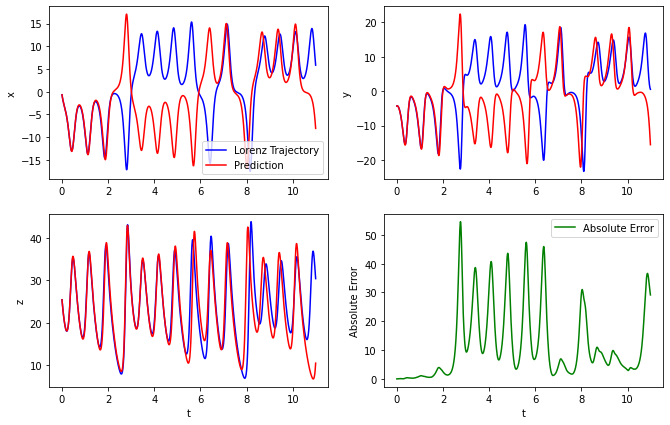

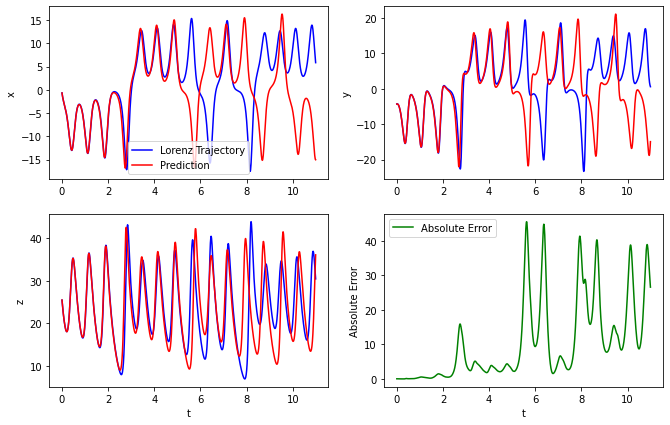

In [8]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
resplt.plot_short_pred(val_data, prediction_sp, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

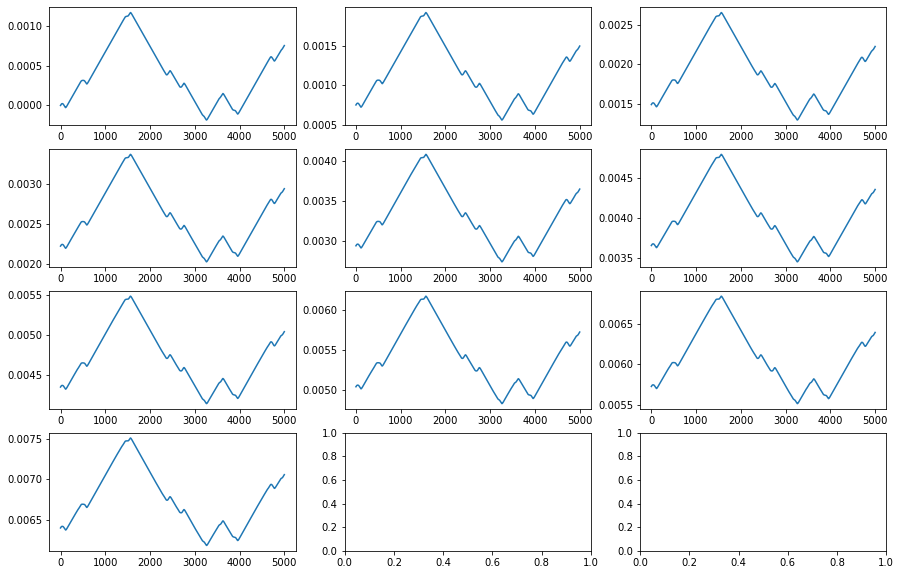

In [9]:
(i, j) = (44, 46)
fig, ax = plt.subplots(4, 3, figsize=(15,10))
ax[0, 0].plot(M_list[0, :, i, j])
ax[0, 1].plot(M_list[1, :, i, j])
ax[0, 2].plot(M_list[2, :, i, j])

ax[1, 0].plot(M_list[3, :, i, j])
ax[1, 1].plot(M_list[4, :, i, j])
ax[1, 2].plot(M_list[5, :, i, j])

ax[2, 0].plot(M_list[6, :, i, j])
ax[2, 1].plot(M_list[7, :, i, j])
ax[2, 2].plot(M_list[8, :, i, j])

ax[3, 0].plot(M_list[9, :, i, j])
#ax[3, 1].plot(M_list[10, :, i, j])
#ax[3, 2].plot(M_list[11, :, i, j])

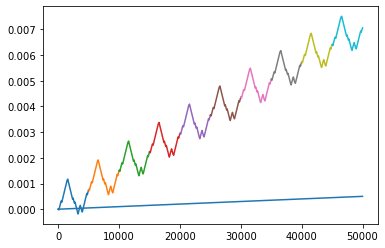

In [10]:
(i, j) = (44, 46)
m = 10**(-8)
steps = np.arange(0, 5000)

for k in range(10):
    plt.plot(steps + k*5000, M_list[k, :, i, j])

plt.plot(np.arange(0, 50000), m*np.arange(0, 50000))

In [11]:
r_cov = np.cov(train_traj.T)

In [12]:
r_cov[i, j]

0.0010093488289795757

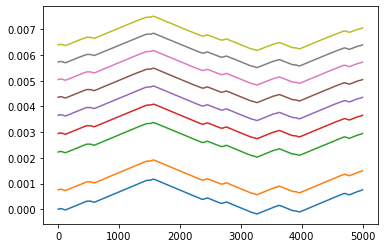

In [13]:
plt.plot(M_list[0, :, i, j])
plt.plot(M_list[1, :, i, j])
ax[0, 2].plot(M_list[2, :, i, j])

plt.plot(M_list[3, :, i, j])
plt.plot(M_list[4, :, i, j])
plt.plot(M_list[5, :, i, j])

plt.plot(M_list[6, :, i, j])
plt.plot(M_list[7, :, i, j])
plt.plot(M_list[8, :, i, j])

plt.plot(M_list[9, :, i, j])

In [14]:
RC = ReCom.SPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_s=1e-6, epochs_s=0)
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
          14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 
          80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 
          180, 190, 200]
M_epoch_list, W_list, cov_list, max_eval_list, tpe_list = [], [], [], [], []

In [15]:
%%time
for e in epochs:
    # Instantiate ESN.
    RC = ReCom.SPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_s=1e-6, epochs_s=e)
    
    # Train M, W_out and generate prediction.
    if e!=0:
        RC.SP_train(train_data, t_points_training, t_listen=5000, reset_M=False)
    train_traj = RC.train(train_data, t_points_training, t_listen=5000)
    prediction = RC.predict(t_points_prediction)
    M = copy.deepcopy(RC.M)
    max_eval = np.abs(sp.linalg.eigs(M, 1, which='LM', return_eigenvectors=False)[0])
    W = copy.deepcopy(RC.W_out)
    r_cov = np.cov(train_traj.T)
    TPE = tpe(prediction, 0.01, lorenz_tpe, alpha)
    
    # Store reservoir state covariance matrix, M, W_out, max eigenvalue
    # of M and testing phase error.
    M_epoch_list.append(M.todense())
    W_list.append(W)
    cov_list.append(r_cov)
    max_eval_list.append(max_eval)
    tpe_list.append(TPE)

Wall time: 1h 23min 29s


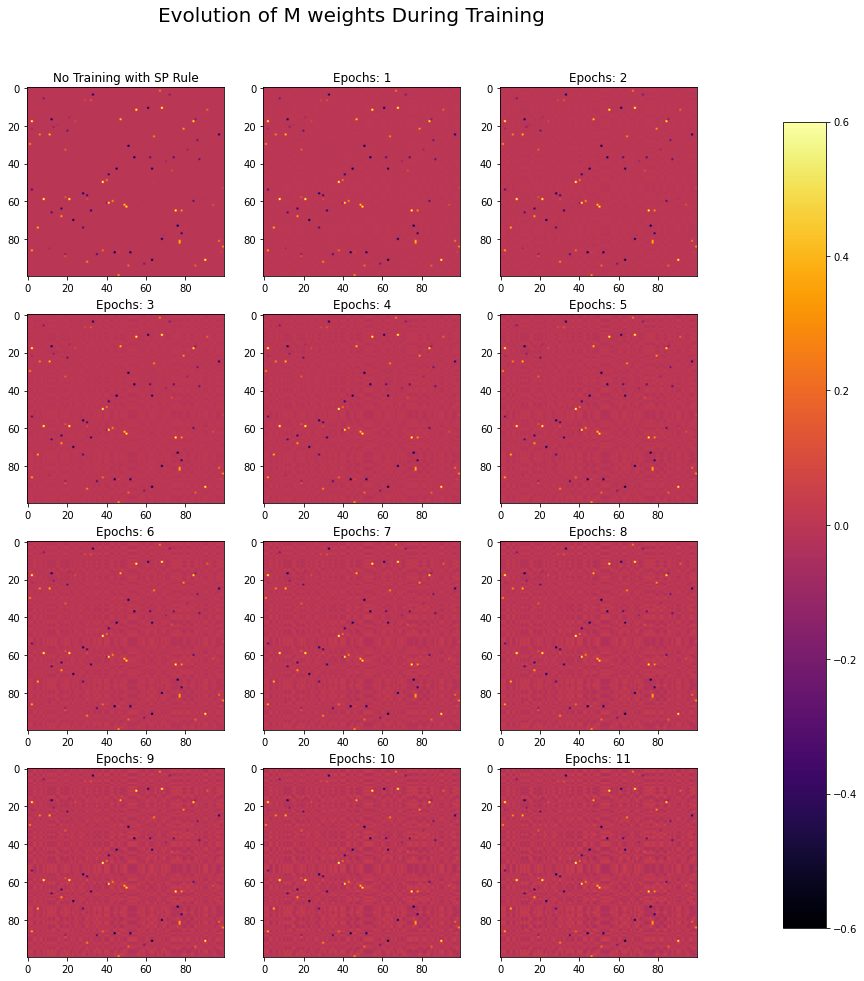

In [78]:
fig = plt.figure(figsize=(12,16))
M_max = M_epoch_list[0].max()
M_min = M_epoch_list[0].min()

for i in range(12):
    M = M_epoch_list[i]
    plt.subplot(4, 3, i+1)
    im = plt.imshow(M, vmax=M_max, vmin=M_min, aspect='auto', cmap='inferno')
    plt.clim(-0.6, 0.6)
    if i == 0:
        plt.title('No Training with SP Rule')
    else:
        plt.title('Epochs: {num_epochs}'.format(num_epochs=epochs[i]))
    
fig.suptitle('Evolution of M weights During Training', fontsize=20, y=0.95)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.clim(-0.6, 0.6)

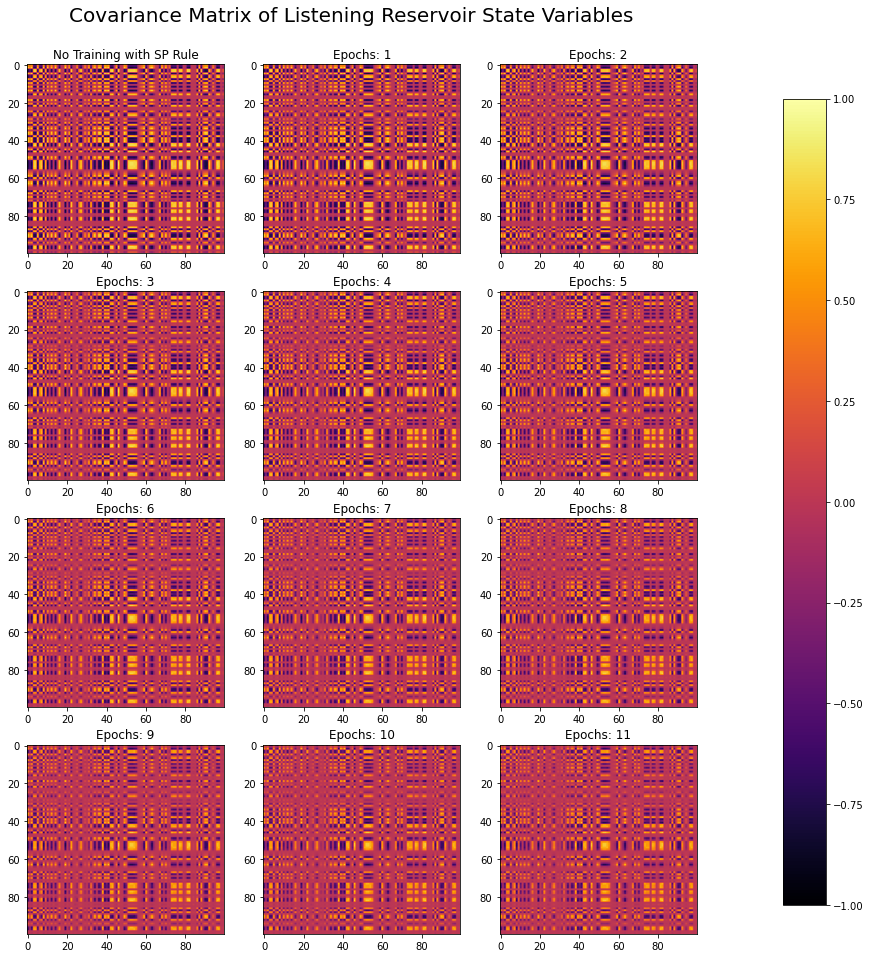

In [61]:
fig = plt.figure(figsize=(12,16))
M_max = M_epoch_list[0].max()
M_min = M_epoch_list[0].min()

for i in range(12):
    M = cov_list[i]
    plt.subplot(4, 3, i+1)
    im = plt.imshow(M, vmax=M_max, vmin=M_min, aspect='auto', cmap='inferno')
    plt.clim(-1, 1)
    if i == 0:
        plt.title('No Training with SP Rule')
    else:
        plt.title('Epochs: {num_epochs}'.format(num_epochs=epochs[i]))
    
fig.suptitle('Covariance Matrix of Listening Reservoir State Variables', fontsize=20, y=0.93)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.clim(-1, 1)

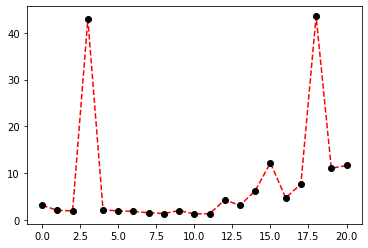

In [16]:
plt.plot(epochs[:21], tpe_list[:21], 'r--')
plt.plot(epochs[:21], tpe_list[:21], 'ko')

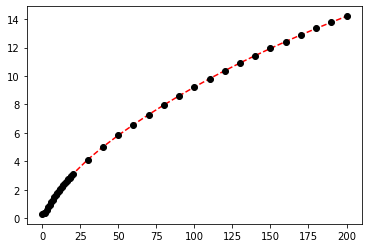

In [17]:
plt.plot(epochs, max_eval_list, 'r--')
plt.plot(epochs, max_eval_list, 'ko')

Text(0, 0.5, '$Cor(r_{0}, r_{10})$')

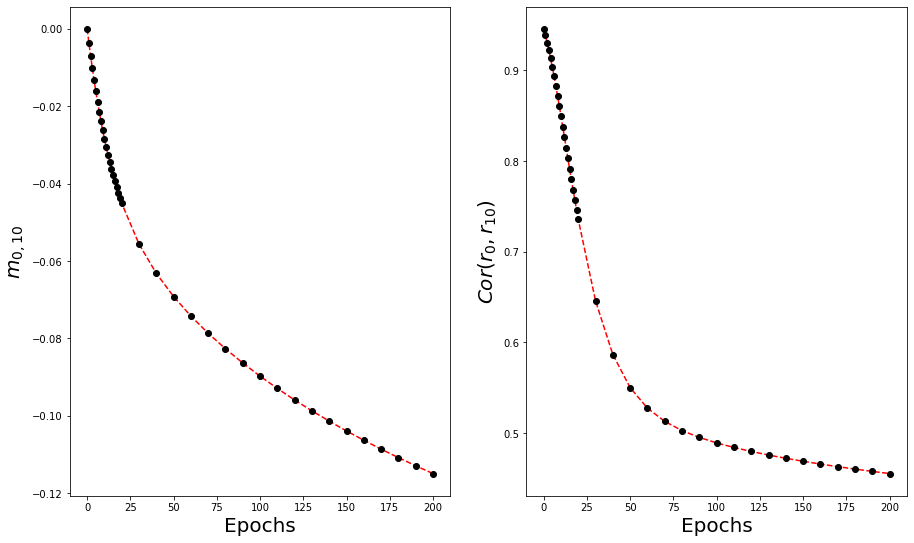

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,9))

ax1.plot(epochs, np.asarray(M_list)[:,0, 10], 'r--')
ax1.plot(epochs, np.asarray(M_list)[:,0, 10], 'ko')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('$m_{0, 10}$', fontsize=20)

ax2.plot(epochs, np.asarray(cor_list)[:,0, 10], 'r--')
ax2.plot(epochs, np.asarray(cor_list)[:,0, 10], 'ko')
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_ylabel('$Cor(r_{0}, r_{10})$', fontsize=20)

Text(0, 0.5, '$Cor(r_{0}, r_{10})$')

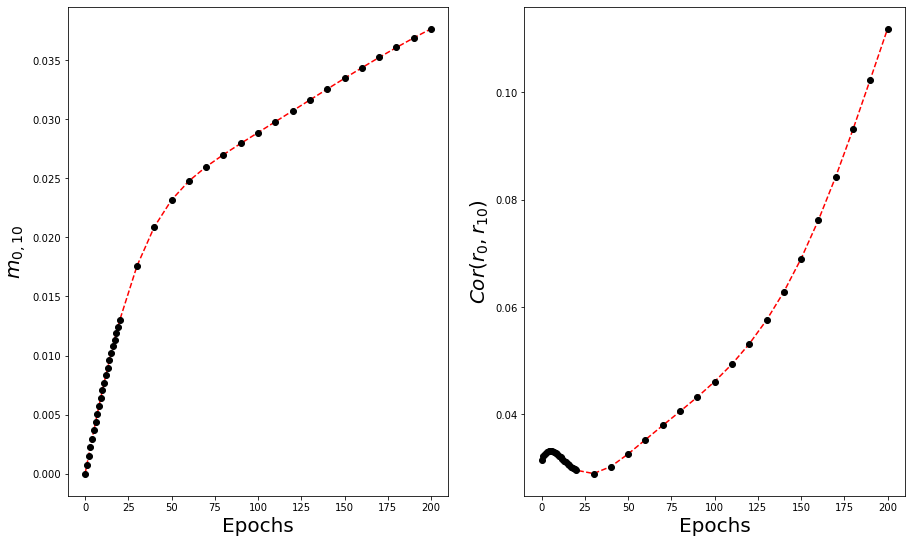

In [33]:
i = 44
j = 46
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,9))

ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'r--')
ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'ko')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('$m_{0, 10}$', fontsize=20)

ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'r--')
ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'ko')
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_ylabel('$Cor(r_{0}, r_{10})$', fontsize=20)

Text(0, 0.5, '$Cor(r_{0}, r_{10})$')

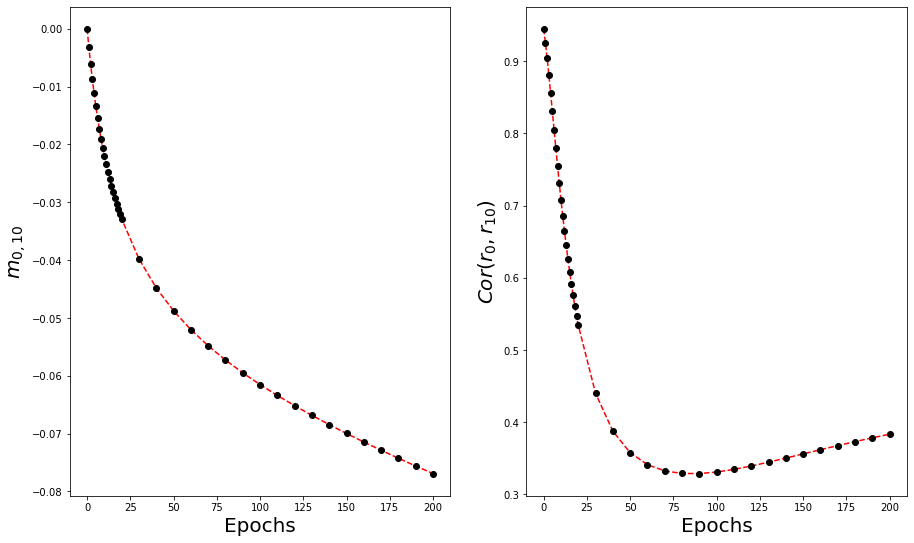

In [34]:
i = 52
j = 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,9))

ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'r--')
ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'ko')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('$m_{0, 10}$', fontsize=20)

ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'r--')
ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'ko')
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_ylabel('$Cor(r_{0}, r_{10})$', fontsize=20)

Text(0, 0.5, '$Cor(r_{0}, r_{10})$')

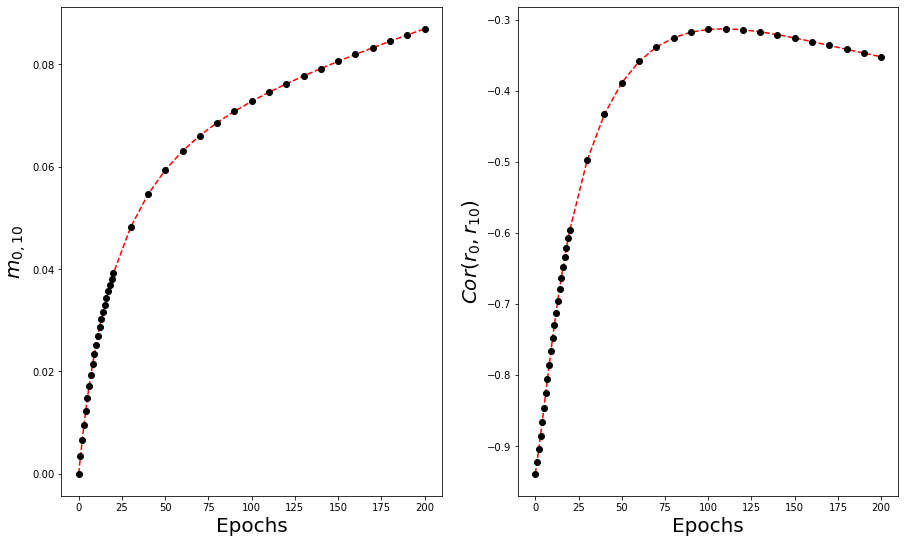

In [35]:
i = 45
j = 46
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,9))

ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'r--')
ax1.plot(epochs, np.asarray(M_list)[:,i, j], 'ko')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('$m_{0, 10}$', fontsize=20)

ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'r--')
ax2.plot(epochs, np.asarray(cor_list)[:,i, j], 'ko')
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_ylabel('$Cor(r_{0}, r_{10})$', fontsize=20)

In [121]:
np.asarray(cov_list)[0,45, 46], np.asarray(M_list)[0, 45, 46]

(-0.6850982199371473, 0.0)

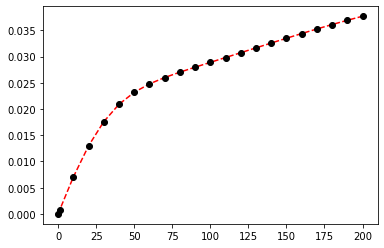

In [151]:
plt.plot(epochs, np.asarray(M_list)[:,44, 46], 'r--')
plt.plot(epochs, np.asarray(M_list)[:,44, 46], 'ko')

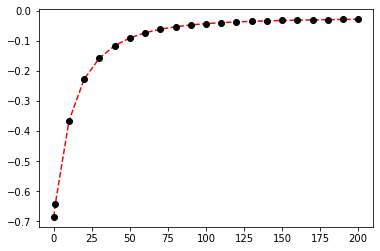

In [152]:
plt.plot(epochs, np.asarray(cov_list)[:,45, 46], 'r--')
plt.plot(epochs, np.asarray(cov_list)[:,45, 46], 'ko')

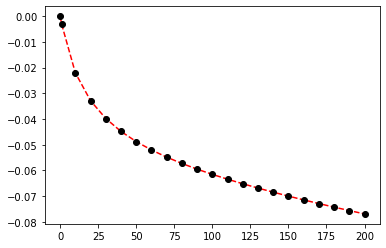

In [153]:
plt.plot(epochs, np.asarray(M_list)[:,52, 9], 'r--')
plt.plot(epochs, np.asarray(M_list)[:,52, 9], 'ko')

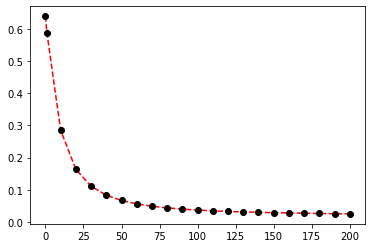

In [154]:
plt.plot(epochs, np.asarray(cov_list)[:,52, 9], 'r--')
plt.plot(epochs, np.asarray(cov_list)[:,52, 9], 'ko')